# Домашняя работа 1.

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.
 - Ноутбук с заданием: https://github.com/artemovae/nlp-course-netology/blob/master/HW1_banki_TM-and-classification.ipynb
 - Данные: https://www.dropbox.com/s/ol3ux3ibr6rd5ke/banki_responses.json.bz2?dl=0

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5.
Тексты хранятся в json-ах в массиве responses.

Решением будет ссылка на гитхаб с ноутбуком.

## Импорт библиотек

In [3]:
import json

import bz2
import regex
from tqdm import tqdm, tqdm_notebook
from scipy import sparse

import re

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Загрузка данных

In [4]:
responses = []
with bz2.BZ2File('../data/banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [01:38, 2043.25it/s]


## Часть 1. Анализ текстов

Поэтапный анализ текста:
1. Посчитайте количество отзывов в разных городах и на разные банки
2. Постройте гистограмы длин слов в символах и в словах
3. Найдите 10 самых частых:
    - слов
    - слов без стоп-слов
    - лемм
    - существительных
4. Постройте кривые Ципфа и Хипса
5. Ответьте на следующие вопросы:
    - какое слово встречается чаще, "сотрудник" или "клиент"?
    - сколько раз встречается слова "мошенничество" и "доверие"?
    - В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [5]:
# Пример отзыва 
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

In [262]:
data = pd.DataFrame(responses)
data.head()

,author,bank_license,bank_name,city,datetime,num_comments,rating_grade,rating_not_checked,text,title
0,uhnov1,лицензия № 2562,Бинбанк,г. Москва,2015-06-08 12:50:54,0,NaN,False,Добрый день! Я не являюсь клиентом банка и пор...,Жалоба
1,Foryou,лицензия № 1481,Сбербанк России,г. Новосибирск,2015-06-08 11:09:57,0,NaN,False,Доброго дня! Являюсь держателем зарплатной кар...,Не могу пользоваться услугой Сбербанк он-лайн
2,Vladimir84,лицензия № 2562,Бинбанк,г. Москва,2015-06-05 20:14:28,1,NaN,False,Здравствуйте! Дублирую свое заявление от 03.0...,Двойное списание за один товар.
3,643609,лицензия № 1481,Сбербанк России,г. Ставрополь,2015-06-05 13:51:01,2,NaN,False,Добрый день!! Я открыл расчетный счет в СберБа...,Меняют проценты комиссии не предупредив и не ...
4,anfisa-2003,лицензия № 2766,ОТП Банк,г. Челябинск,2015-06-05 10:58:12,1,NaN,False,"04.03.2015 г. взяла кредит в вашем банке, заяв...",Верните денежные средства за страховку


In [263]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 10 columns):
author                153479 non-null object
bank_license          153498 non-null object
bank_name             153499 non-null object
city                  138325 non-null object
datetime              153499 non-null object
num_comments          153499 non-null int64
rating_grade          88658 non-null float64
rating_not_checked    153499 non-null bool
text                  153499 non-null object
title                 153499 non-null object
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 10.7+ MB


Поэтапный анализ текста:
1. Посчитайте количество отзывов в разных городах и на разные банки
2. Постройте гистограмы длин слов в символах и в словах
3. Найдите 10 самых частых:
    - слов
    - слов без стоп-слов
    - лемм
    - существительных
4. Постройте кривые Ципфа и Хипса
5. Ответьте на следующие вопросы:
    - какое слово встречается чаще, "сотрудник" или "клиент"?
    - сколько раз встречается слова "мошенничество" и "доверие"?
    - В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

###### 1. Количество отзывов в разных городах и на разные банки

In [264]:
cities = data.loc[:, 'city'].copy()

In [265]:
# Для того чтобы выделить названия городов, попробуем использовать токенайзер natasha
import natasha
from natasha import LocationExtractor

In [266]:
extractor = LocationExtractor()

def extract_city(text, extractor=extractor):
    try:
        matches = extractor(text)
        start, stop = matches[0].span
        return text[start:stop].lower()
    except:
        return ''

cities_transformed = cities.apply(extract_city)

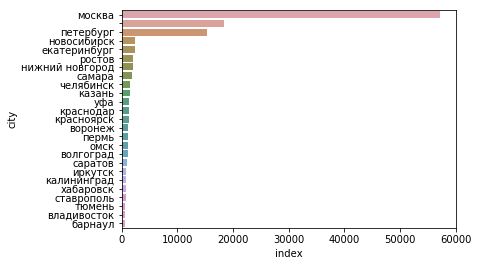

In [267]:
cities_extracted = cities_transformed.reset_index().groupby('city').count().sort_values('index', ascending=False)
sns.barplot(data=cities_extracted.reset_index().head(25), x='index', y='city', saturation=.5)

##### Количество отзывов по банкам

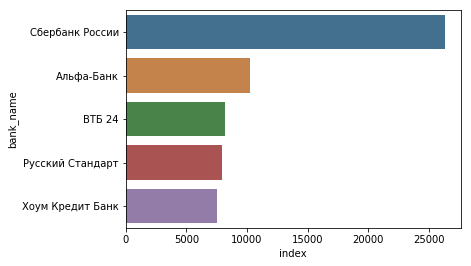

In [268]:
bank_names = data.loc[:,['bank_name']].copy()
banks = bank_names.reset_index().groupby('bank_name').count().sort_values('index', ascending=False).head(5)
sns.barplot(data=banks.reset_index(), x='index', y='bank_name', saturation=.5)

In [269]:
regex = r'г\. ([А-Яа-я- ]+)'
def get_city(text, regex=regex):
    try:
        values = re.findall(regex, text)
        return ' '.join(values).lower()
    except:
        return ""

###### Гистограмы длин слов в символах

In [270]:
regex = '[А-Яа-я]+'
from nltk.corpus import stopwords
from pymystem3 import Mystem
from pymorphy2 import MorphAnalyzer


rus_stopwords = stopwords.words('russian')
lemmatizator = Mystem()
pm2 = MorphAnalyzer()

def words_only(text, regex=regex):
    try:
        value = ' '.join(re.findall(regex, text)).lower()
        return value
    except:
        return ''
    
def drop_stopwords(text, stopwords=rus_stopwords):
    try:
        value = ' '.join([token for token in text.split() if not token in stopwords])
        return value
    except:
        return ''
    
def lemmatize(text, converter=pm2):
    try:
        value = [converter.parse(word)[0].normal_form for word in text.split()]
        return ' '.join(value)
    except:
        return ''
    
def nounizator(text, converter=pm2):
    try:
        value = [converter.parse(word)[0].normal_form for word in text.split() 
                              if 'NOUN' in converter.parse(word)[0].tag]
        return ' '.join(value)
    except:
        return ''

In [271]:
texts = data.text.apply(words_only)

In [14]:
from collections import Counter
cnt = Counter()
len_cnt = Counter()
tokens = []
for i, text in tqdm_notebook(texts.iteritems()):
    # Слова
    tokens = [i for i in text.split()]
    cnt.update(tokens)
    # Длины слов
    len_tokens = [len(i) for i in text.split()]
    len_cnt.update(len_tokens)

In [15]:
# Настройка размера графика
sns.set(rc={'figure.figsize':(10,4)})

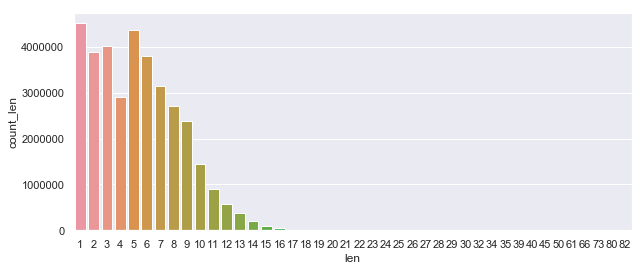

In [16]:
# Гистограмма длин слов в символах
word_lens = pd.DataFrame.from_dict(dict(len_cnt), orient='index').reset_index()
word_lens.columns = ['len', 'count_len']
sns.barplot(data=word_lens, x='len', y='count_len', ci=10)

###### Гистограма длин предложений в словах

In [17]:
from nltk.tokenize import sent_tokenize
text_sentences = data.text.apply(sent_tokenize)

In [18]:
len_sent = Counter()
sentenses = []
for i, text in tqdm_notebook(text_sentences.iteritems()):
    # Предложения
    for sentense in text:
        words = words_only(sentense).split()
        len_sent.update([len(words)])

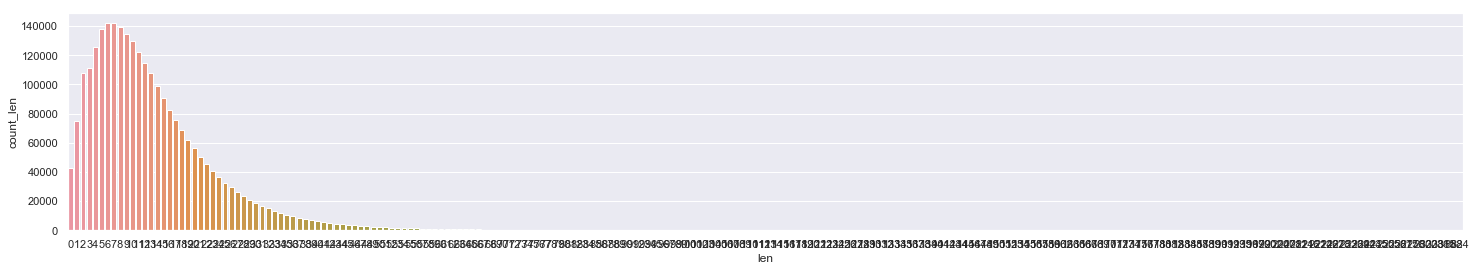

In [19]:
# Настройка графика
sns.set(rc={'figure.figsize':(25,4)})

# Гистограмма длин предложений в словах
sent_lens = pd.DataFrame.from_dict(dict(len_sent), orient='index').reset_index()
sent_lens.columns = ['len', 'count_len']
sns.barplot(data=sent_lens, x='len', y='count_len', ci=10)

###### Частотный анализ
10 самых частых:
 - слов
 - слов без стоп-слов
 - лемм
 - существительных

In [39]:
words_cnt = Counter()
words_stop_off = Counter()
lemmas_cnt = Counter()
nouns_cnt = Counter()

n_types = []
n_tokens = []

for i, text in tqdm_notebook(texts.head(5000).iteritems()):
    # Считаем самые частые слова
    words_cnt.update(text.split())
    # Убираем стоп-слова
    clean_text_without_stop_words = drop_stopwords(text)
    words_stop_off.update(clean_text_without_stop_words.split())
    # Лемма и сцществительные
    nouns = nounizator(clean_text_without_stop_words)
    lemmas = lemmatize(clean_text_without_stop_words)
    lemmas_cnt.update(lemmas)
    nouns_cnt.update(nouns)
    # Инфа для закона Хипса - зависимость от количества слов
    n_types.append(len(lemmas_cnt))
    n_tokens.append(np.sum(lemmas_cnt[item] for item in lemmas_cnt))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.


In [40]:
# 10 Самых частых слов
words_cnt.most_common(10)

[('в', 37223),
 ('и', 30266),
 ('не', 24950),
 ('на', 20386),
 ('что', 17935),
 ('я', 16774),
 ('с', 14048),
 ('по', 11323),
 ('мне', 9421),
 ('банка', 8566)]

In [41]:
# 10 Самых частых слов без стоп слов
words_stop_off.most_common(10)

[('банка', 8566),
 ('банк', 6868),
 ('это', 5076),
 ('деньги', 3472),
 ('карты', 3095),
 ('карту', 2940),
 ('т', 2700),
 ('день', 2411),
 ('кредит', 2376),
 ('г', 2239)]

In [42]:
# 10 Самых частых лемм
lemmas_cnt.most_common(10)

[('банка', 12163),
 ('карта', 9722),
 ('банк', 8507),
 ('это', 5770),
 ('год', 5624),
 ('мой', 5102),
 ('кредит', 4956),
 ('день', 4929),
 ('деньга', 4676),
 ('сотрудник', 4508)]

In [43]:
# 10 Самых частых существительных
nouns_cnt.most_common(10)

[('банка', 12163),
 ('карта', 9722),
 ('банк', 8507),
 ('год', 5624),
 ('кредит', 4956),
 ('день', 4929),
 ('деньга', 4676),
 ('сотрудник', 4508),
 ('клиент', 4008),
 ('отделение', 3437)]

##### Кривая Ципфа

**Зако́н Ци́пфа («ранг—частота»)** — эмпирическая закономерность распределения частоты слов естественного языка: если все слова языка (или просто достаточно длинного текста) упорядочить по убыванию частоты их использования, то частота n-го слова в таком списке окажется приблизительно обратно пропорциональной его порядковому номеру n (так называемому рангу этого слова, см. шкала порядка). 

Например, второе по используемости слово встречается примерно в два раза реже, чем первое, третье — в три раза реже, чем первое, и так далее.

**Определение**

В любом достаточно большом тексте ранг типа обратно пропорционален его частоте: $f = \frac{a}{r}$

$f$ – частота типа, $r$  – ранг типа, $a$  – параметр, для славянских языков – около 0.07

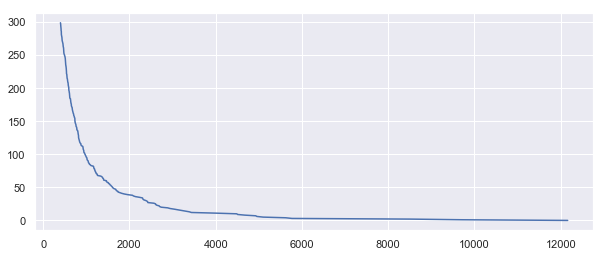

In [44]:
# Настройка графика
sns.set(rc={'figure.figsize':(10,4)})

# В качестве типа слова будем использовать лемму
freqs = list(lemmas_cnt.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.show()

##### Кривая Хипса
С увеличением длины текста (количества токенов), количество типов увеличивается в соответствии с законом: $|V| = K*N^b$


$N$  –  число токенов, $|V|$  – количество типов в словаре, $K, b$  –  параметры, обычно $K \in [10,100], b \in [0.4, 0.6]$

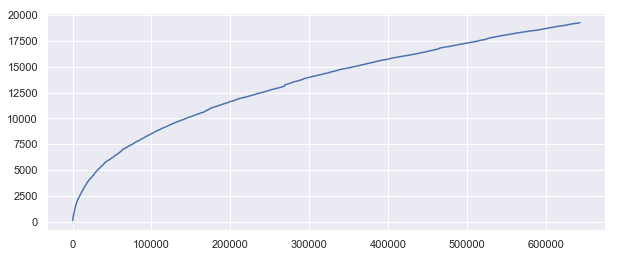

In [45]:
fig, ax = plt.subplots()
ax.plot(n_tokens, n_types)
plt.show()

#### Ответы на вопросы
- какое слово встречается чаще, "сотрудник" или "клиент"?   

In [46]:
def sort_values(word1, word2, cnt=lemmas_cnt):
    try:
        if cnt[word1]>cnt[word2]:
            return [word1, word2]
        else:
            return [word2, word1]
    except:
        return ['-', '-']
    
print("Слово '{0}' встречается чаще слова '{1}'".format(sort_values('сотрудник', 'клиент')[0], 
                                                        sort_values('сотрудник', 'клиент')[1]))

Слово 'сотрудник' встречается чаще слова 'клиент'


- сколько раз встречается слова "мошенничество" и "доверие"?    

In [47]:
print("Слово {0} встречается {1} раз".format('мошенничество', lemmas_cnt['мошенничество']))
print("Слово {0} встречается {1} раз".format('доверие', lemmas_cnt['доверие']))

Слово мошенничество встречается 116 раз
Слово доверие встречается 85 раз


### Задача - поиск положительных отзывов

- В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру  $𝑡𝑓−𝑖𝑑𝑓$ , для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [35]:
# Поскольку тут придется работать с текстами различных объемов, 
# соберем сбалансированный датасет из отзывов различных рейтингов
NUM_ROWS = 150

dataset = data[(data.rating_grade==1)].sample(NUM_ROWS).copy()
dataset = dataset.append(data[(data.rating_grade==2)].sample(NUM_ROWS))
dataset = dataset.append(data[(data.rating_grade==3)].sample(NUM_ROWS))
dataset = dataset.append(data[(data.rating_grade==4)].sample(NUM_ROWS))
dataset = dataset.append(data[(data.rating_grade==5)].sample(NUM_ROWS))

dataset['text'] = dataset.apply(lambda row: words_only(row['text']), axis=1)
dataset['text'] = dataset.apply(lambda row: drop_stopwords(row['text']), axis=1)
dataset['lemmas'] = dataset.apply(lambda row: lemmatize(row['text']), axis=1)
dataset['nouns'] = dataset.apply(lambda row: nounizator(row['lemmas']), axis=1)

In [36]:
tokens_by_rating = []

for rating_grade in dataset.rating_grade.unique():
    if dataset['rating_grade'].value_counts()[rating_grade] > 100: 
        print(rating_grade)
        tokens = []
        sample = dataset[dataset['rating_grade']==rating_grade]
        
        for i in range(len(sample)):
            tokens += sample.text.iloc[i].split()
        tokens_by_rating.append(tokens)

1.0
2.0
3.0
4.0
5.0


###### Определим по 20 ключевых слов для положительных и отрицательных отзывов

In [90]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 0)
tfidf_matrix = tfidf.fit_transform([' '.join(tokens) for tokens in tokens_by_rating])
feature_names = tfidf.get_feature_names() 
tfidf_positive_ranking = []
tfidf_negative_ranking = []
dense = tfidf_matrix.todense()

text = dense[4].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:50]:
    tfidf_positive_ranking.append(phrase)

text = dense[0].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:50]:
    tfidf_negative_ranking.append(phrase)

Очевидно, что перед тем как определять ключевые слова для позитивных и негативных отзывов, необходимо исключить стоп слова из текстов.

Но без определения таких стоп слов, можно использовать исключение негативных ключевых слов из позитивных и наоборот.

In [51]:
# ключевые слова для негативных отзывов
[i for i in tfidf_negative_ranking if not i in tfidf_positive_ranking]

['заявление',
 'почему',
 'ответ',
 'сумму',
 'рублей',
 'вопрос',
 'сказали',
 'смс',
 'могу',
 'номер',
 'руб',
 'телефону',
 'никто',
 'который',
 'моей',
 'договора',
 'счета',
 'заявку',
 'месяц',
 'хотя']

In [53]:
# ключевые слова для позитивных отзывов
[i for i in tfidf_positive_ranking if not i in tfidf_negative_ranking]

['спасибо',
 'быстро',
 'интернет',
 'обслуживание',
 'хочу',
 'вс',
 'вклад',
 'банку',
 'сразу',
 'сотрудников',
 'вопросы',
 'приятно',
 'клиентом',
 'банков',
 'дня',
 'клиентов',
 'всем',
 'очереди',
 'пока',
 'удобно']

###### Определим 20 биграм для положительных и отрицательных отзывов

In [67]:
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(2,2), min_df = 0)
tfidf_matrix = tfidf.fit_transform([' '.join(tokens) for tokens in tokens_by_rating])
feature_names = tfidf.get_feature_names() 
tfidf_positive_ranking = []
tfidf_negative_ranking = []
dense = tfidf_matrix.todense()

text = dense[4].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:50]:
    tfidf_positive_ranking.append(phrase)

text = dense[0].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:50]:
    tfidf_negative_ranking.append(phrase)

In [69]:
tfidf_negative_ranking[0:20]

['отделение банка',
 'сих пор',
 'следующий день',
 'написать заявление',
 'сотрудники сбербанка',
 'тыс руб',
 'добрый день',
 'сотрудники банка',
 'кредитный счет',
 'вопрос почему',
 'службу поддержки',
 'биллинг адрес',
 'недели назад',
 'тыс рубл',
 'денежных средств',
 'интернет банк',
 'кредитной карты',
 'кредитную линию',
 'досрочное погашение',
 'таким образом']

In [70]:
tfidf_positive_ranking[0:20]

['следующий день',
 'интернет банк',
 'добрый день',
 'хочу выразить',
 'очень быстро',
 'являюсь клиентом',
 'других банках',
 'клиентом банка',
 'хочу поблагодарить',
 'интернет банкинг',
 'отдельное спасибо',
 'очень приятно',
 'день день',
 'данного банка',
 'альфа банк',
 'другом банке',
 'очень удобно',
 'никаких проблем',
 'сотрудник банка',
 'исчерпывающие ответы']

## Часть 2. Тематическое моделирование [20/100]

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

Эта часть задания может быть сделана с использованием gensim. 

In [102]:
stoplemmas = ['банка', 'это', 'банк',  'карты',   'карту',  
              'отделение',   'день',  'банке',  'года',  
              'просто',  'очень',  'отделении',  'дней',  
              'несколько',  'минут',  'отделения',  
              'девушка',  'денег',  'банком',  'офис']

def drop_stoplemmas(text, stoplemmas = stoplemmas):
    try:
        return " ".join([token for token in text.split() if not token in stoplemmas])
    except:
        return ""

In [103]:
from gensim import corpora, models
import gensim

In [109]:
from gensim import corpora, models

dictionary = corpora.Dictionary(dataset.nouns.apply(drop_stoplemmas).str.split())
corpus = [dictionary.doc2bow(text) for text in dataset.nouns.apply(drop_stoplemmas).str.split()]

In [110]:
%time ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word = dictionary, passes=20)

CPU times: user 16.7 s, sys: 142 ms, total: 16.8 s
Wall time: 17 s


In [111]:
ldamodel.print_topics(num_topics=5, num_words=5)

[(0,
  '0.028*"кредит" + 0.018*"сотрудник" + 0.014*"документ" + 0.013*"год" + 0.012*"клиент"'),
 (1,
  '0.026*"клиент" + 0.021*"очередь" + 0.018*"сотрудник" + 0.017*"банкомат" + 0.017*"деньга"'),
 (2,
  '0.017*"вклад" + 0.017*"клиент" + 0.012*"операционистка" + 0.012*"вопрос" + 0.006*"решение"'),
 (3,
  '0.087*"карта" + 0.021*"деньга" + 0.016*"счёт" + 0.013*"заявление" + 0.013*"клиент"'),
 (4,
  '0.030*"рубль" + 0.029*"кредит" + 0.028*"сумма" + 0.025*"год" + 0.024*"счёт"')]

In [112]:
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis)

##### Рассмотрим темы, которые возникают при анализе Сбербанка

In [120]:
dataset.bank_name.value_counts().head()

Сбербанк России     92
Альфа-Банк          50
ВТБ 24              38
Русский Стандарт    33
Хоум Кредит Банк    31
Name: bank_name, dtype: int64

In [122]:
from gensim import corpora, models

dictionary = corpora.Dictionary(dataset[(dataset.bank_name=='Сбербанк России')].nouns.apply(drop_stoplemmas).str.split())
corpus = [dictionary.doc2bow(text) for text in dataset.nouns.apply(drop_stoplemmas).str.split()]

In [123]:
%time ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word = dictionary, passes=20)

CPU times: user 15.6 s, sys: 45.5 ms, total: 15.7 s
Wall time: 15.7 s


In [124]:
ldamodel.print_topics(num_topics=5, num_words=5)

[(0,
  '0.064*"кредит" + 0.029*"заявка" + 0.024*"договор" + 0.020*"год" + 0.020*"документ"'),
 (1,
  '0.063*"деньга" + 0.040*"банкомат" + 0.037*"счёт" + 0.037*"рубль" + 0.032*"сумма"'),
 (2,
  '0.030*"клиент" + 0.029*"сотрудник" + 0.019*"год" + 0.017*"счёт" + 0.017*"документ"'),
 (3,
  '0.129*"карта" + 0.018*"заявление" + 0.017*"год" + 0.017*"интернет" + 0.016*"счёт"'),
 (4,
  '0.073*"вклад" + 0.036*"очередь" + 0.031*"клиент" + 0.022*"касса" + 0.020*"минута"')]

In [125]:
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis)

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


## Часть 3. Классификация текстов [40/100]

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5). 

1.  Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте ```sklearn.model_selection.train_test_split``` для разделения множества отобранных документов на обучающее и тестовое. 
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам. 
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
* 1-ый вариант: $tf-idf$ преобразование (```sklearn.feature_extraction.text.TfidfTransformer```) и сингулярное разложение (оно же – латентый семантический анализ) (```sklearn.decomposition.TruncatedSVD```), 
* 2-ой вариант: тематические модели LDA (```sklearn.decomposition.LatentDirichletAllocation```). 

Используйте accuracy и F-measure для оценки качества классификации. 

Ниже написан примерный Pipeline для классификации текстов. 

Эта часть задания может быть сделана с использованием sklearn. 

In [144]:
# Поскольку тут придется работать с текстами различных объемов, 
# соберем сбалансированный датасет из отзывов различных рейтингов
NUM_ROWS = 350

dataset_clf = data[(data.rating_grade==1)].sample(NUM_ROWS).copy()
dataset_clf = dataset_clf.append(data[(data.rating_grade==5)].sample(NUM_ROWS).copy())

dataset_clf['text'] = dataset_clf.apply(lambda row: words_only(row['text']), axis=1)
dataset_clf['text'] = dataset_clf.apply(lambda row: drop_stopwords(row['text']), axis=1)
dataset_clf['lemmas'] = dataset_clf.apply(lambda row: lemmatize(row['text']), axis=1)

In [247]:
# Соберем датасет с обучающей и тестовой выборкой
from sklearn.model_selection import train_test_split

X = dataset_clf.text
y = dataset_clf.rating_grade
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [259]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# 1-ый вариант: tf-idf + LSI
clf = Pipeline([ 
    ('tfidf', None), 
    ('decomp', None), 
    ('clf', LogisticRegression(solver='lbfgs'))
])

NGRAM_WORD_OPTIONS = [(1,1),(2,2),(3,3)]
NGRAM_CHAR_OPTIONS = [(3,4)]
DECOMP_OPTIONS = [50, 60, 90]
param_grid = [
    # 1-й вариант: сингулярное разложение и TfIdf
    {
        'tfidf': [TfidfVectorizer(analyzer='word')],
        'tfidf__ngram_range': NGRAM_WORD_OPTIONS,
        'decomp': [TruncatedSVD(), LatentDirichletAllocation()],
        'decomp__n_components': DECOMP_OPTIONS,
    },
    {
        'tfidf': [TfidfVectorizer(analyzer='char')],
        'tfidf__ngram_range': NGRAM_CHAR_OPTIONS,
        'decomp': [TruncatedSVD(), LatentDirichletAllocation()],
        'decomp__n_components': DECOMP_OPTIONS,
    },
]

SCORES = ['f1', 'accuracy']

grid_tfidf_svd = GridSearchCV(clf, cv=5, n_jobs=1, param_grid=param_grid, scoring=SCORES, refit='accuracy', return_train_score=True)

grid_tfidf_svd.fit(X_train, y_train)
grid_tfidf_svd.best_estimator_.steps

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-sco

[('tfidf',
  TfidfVectorizer(analyzer='char', binary=False, decode_error='strict',
          dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
          lowercase=True, max_df=1.0, max_features=None, min_df=1,
          ngram_range=(3, 4), norm='l2', preprocessor=None, smooth_idf=True,
          stop_words=None, strip_accents=None, sublinear_tf=False,
          token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
          vocabulary=None)),
 ('decomp', TruncatedSVD(algorithm='randomized', n_components=90, n_iter=5,
         random_state=None, tol=0.0)),
 ('clf',
  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='warn',
            n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
            tol=0.0001, verbose=0, warm_start=False))]

In [260]:
predictions = grid_tfidf_svd.best_estimator_.predict(X_test)
print("Результат обучения модели:\n F1 Score = {0} \n Accuracy = {1}"\
          .format(f1_score(predictions, y_test), accuracy_score(predictions, y_test)))

Результат обучения модели:
 F1 Score = 0.923076923076923 
 Accuracy = 0.9142857142857143


In [261]:
# Анализ полученных моделей для различных n-грамм на основе tfidf и сингулярного разложения
svd_models = pd.DataFrame.from_dict(grid_tfidf_svd.cv_results_)
svd_models = svd_models[['param_tfidf', 'param_tfidf__ngram_range', 'param_decomp', 'param_decomp__n_components', 
        'mean_test_f1', 'mean_test_accuracy']]
svd_models['param_tfidf'] = svd_models.param_tfidf.apply(lambda row: row.analyzer)
svd_models['param_decomp'] = svd_models.param_decomp.apply(lambda row: row.__class__.__name__)
svd_models.sort_values('mean_test_accuracy', ascending=False)

,param_tfidf,param_tfidf__ngram_range,param_decomp,param_decomp__n_components,mean_test_f1,mean_test_accuracy
20,char,"(3, 4)",TruncatedSVD,90,0.851664,0.860714
19,char,"(3, 4)",TruncatedSVD,60,0.847893,0.857143
6,word,"(1, 1)",TruncatedSVD,90,0.847971,0.857143
0,word,"(1, 1)",TruncatedSVD,50,0.846502,0.855357
18,char,"(3, 4)",TruncatedSVD,50,0.842039,0.851786
3,word,"(1, 1)",TruncatedSVD,60,0.836960,0.848214
7,word,"(2, 2)",TruncatedSVD,90,0.464405,0.653571
12,word,"(1, 1)",LatentDirichletAllocation,60,0.597787,0.653571
15,word,"(1, 1)",LatentDirichletAllocation,90,0.578229,0.651786
4,word,"(2, 2)",TruncatedSVD,60,0.333616,0.608929
